In [5]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta, chisquare
from scipy.sparse.linalg import lsqr
from utils import *

In [79]:
def gaussian_stack_inversion(n, p, z_min, z_max, q_dist, s_sqr, tot_mass, sample_dev, scaling_factor=1, solver='lsqr'):
    # Release points in column
    z = np.linspace(z_min, z_max, p)

    # Landing points of release point centers
    x_bar = [landing_point(0, zk, u, v) for zk in z]

    #Mass distribution in the plume
    q_mass = mass_dist_in_plume(q_dist, z_min, z_max, z, tot_mass)
    
    q = q_mass*scaling_factor
    
    input_data = np.asarray([z, np.asarray(q_mass), np.asarray(q), np.asarray(x_bar)]).T
    input_table = pd.DataFrame(input_data,  columns=["Release Height (z)", 
                                                     "Suspended Mass (q)", 
                                                     "Scaled Mass (q)", 
                                                     "Landing Points (x_bar)"])
    
    xx = np.linspace(x_bar[0] - 100000, x_bar[-1] + 100000, 500)
    x_range = xx[-1] - xx[0]
    yy = np.linspace(-x_range/2, x_range/2, 500)
    X, Y = np.meshgrid(xx, yy)
    dep_mass = np.zeros(X.shape)
    sus_mass = []
    for k, zh in enumerate(z):
        # Gaussian dispersal
        dist = f(X, Y, s_sqr, x_bar[k], y_bar=0)
        sus_dist = f(X, Y, s_sqr, 0, y_bar=0)
        dep_mass += dist*q[k]
        sus_mass.append(sus_dist*q[k])
        
    max_point = xx[np.unravel_index(dep_mass.argmax(), dep_mass.shape)[0]]

    samp_mean = [max_point, 0]
    samp_cov = [[sample_dev, 0], [0, s_sqr]]
    samp_x, samp_y = np.random.multivariate_normal(samp_mean, samp_cov, n).T
    
    A = np.zeros((n,p))
    for i in range(n):
        for k in range(p):
            A[i,k] = f(samp_x[i], samp_y[i], s_sqr, x_bar[k], 0)
    coefficient_matrix = pd.DataFrame(A)
    if n == p:
        det = np.linalg.det(A)
    else: 
        det = None
    rank = np.linalg.matrix_rank(A)
    m = np.matmul(A, q)
    
    sample_data = np.asarray([samp_x, samp_y, m]).T
    sample_table = pd.DataFrame(sample_data, columns=["X", "Y", "Deposit Mass"])
    
    if solver=='lsqr':
        lst_q = lsqr(A, m)
        q_inv = np.asarray(lst_q[0])
    elif solver=='jacobi':
        P = np.diag(np.diag(A))
        P_inv = np.linalg.inv(P)
        cond_A = np.matmul(A, P_inv)
        print(np.linalg.det(cond_A))
        y_sol = np.linalg.solve(cond_A, m)
        q_inv = np.linalg.solve(P, y_sol)
    else:
        q_inv = np.linalg.solve(A, m)
    q_inv_mass = q_inv/scaling_factor
    res = q_mass - q_inv_mass
    res_perc = (res/(q_mass))*100
    inversion_data = np.asarray([np.asarray(z), np.asarray(q_mass), np.asarray(q), q_inv, q_inv_mass, res, res_perc]).T
    inversion_table = pd.DataFrame(inversion_data, columns=["Height", "Suspended Mass", "Scaled Mass",  "Scaled Inverted Mass", "Inverted Mass", "Residual", "Residual Percentage"])
    return inversion_table, sample_table, coefficient_matrix, input_table, det, rank

In [80]:
s_sqr = 1e9

# Terminal Fall Velocity
v = -9.4

# Wind Speed
u = 30

c:\users\nmostert\envs\spew\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in true_divide


,Release Height (z),Suspended Mass (q),Scaled Mass (q),Landing Points (x_bar)
0,0.000000,0.000000e+00,0.000000e+00,0.000000
1,303.030303,1.224365e+05,1.224365e+05,967.117988
2,606.060606,4.847485e+05,4.847485e+05,1934.235977
3,909.090909,1.079440e+06,1.079440e+06,2901.353965
4,1212.121212,1.899015e+06,1.899015e+06,3868.471954
5,1515.151515,2.935977e+06,2.935977e+06,4835.589942
6,1818.181818,4.182830e+06,4.182830e+06,5802.707930
7,2121.212121,5.632078e+06,5.632078e+06,6769.825919
8,2424.242424,7.276225e+06,7.276225e+06,7736.943907
9,2727.272727,9.107775e+06,9.107775e+06,8704.061896


,Height,Suspended Mass,Scaled Mass,Scaled Inverted Mass,Inverted Mass,Residual,Residual Percentage
0,0.000000,0.000000e+00,0.000000e+00,8.203661e+03,8.203661e+03,-8203.660921,-inf
1,303.030303,1.224365e+05,1.224365e+05,1.334970e+05,1.334970e+05,-11060.506223,-9.033668
2,606.060606,4.847485e+05,4.847485e+05,4.944572e+05,4.944572e+05,-9708.712117,-2.002835
3,909.090909,1.079440e+06,1.079440e+06,1.085290e+06,1.085290e+06,-5849.764008,-0.541926
4,1212.121212,1.899015e+06,1.899015e+06,1.899828e+06,1.899828e+06,-813.037274,-0.042814
5,1515.151515,2.935977e+06,2.935977e+06,2.931578e+06,2.931578e+06,4399.005378,0.149831
6,1818.181818,4.182830e+06,4.182830e+06,4.173763e+06,4.173763e+06,9067.310866,0.216775
7,2121.212121,5.632078e+06,5.632078e+06,5.619364e+06,5.619364e+06,12714.745360,0.225756
8,2424.242424,7.276225e+06,7.276225e+06,7.261159e+06,7.261159e+06,15066.896875,0.207070
9,2727.272727,9.107775e+06,9.107775e+06,9.091760e+06,9.091760e+06,16015.410998,0.175843


Residual Sum of Squares: 51553716686.86546
Determinant of A (if square): None
Rank of A: 17


<IPython.core.display.Javascript object>


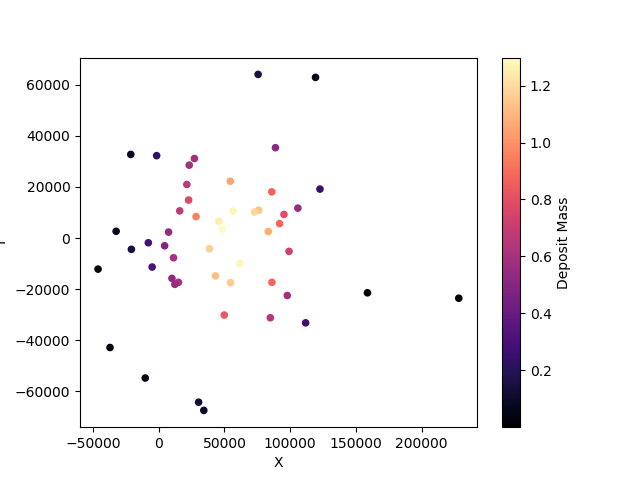

<IPython.core.display.Javascript object>


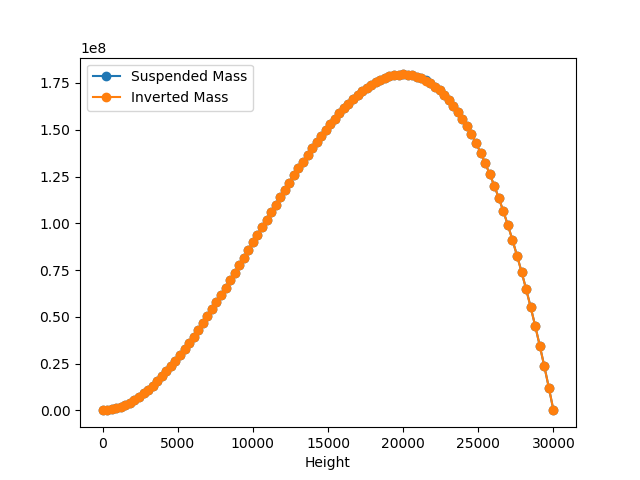

<IPython.core.display.Javascript object>


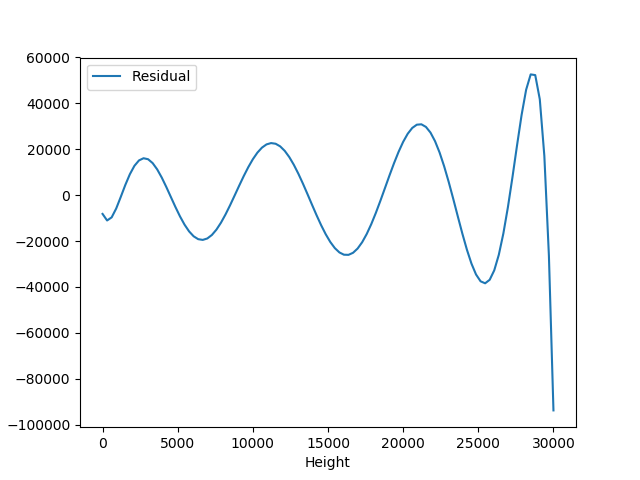

<IPython.core.display.Javascript object>


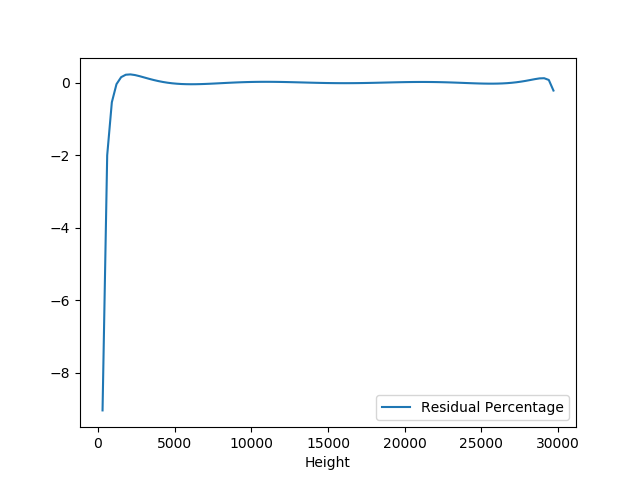

In [81]:
# sample std in the downwind direction
sample_dev =3*s_sqr 

# Bottom and top of plume
z_min = 0
z_max = 30000

# Mass ditribution in the plume
a = 3
b = 2
q_dist = beta(a,b)

# Total Mass
tot_mass = 1e10

# Number of samples on the ground
n = 50

# Number of levels in the column
p = 100

inversion_table, sample_table, coefficient_matrix, input_table, det, rank = gaussian_stack_inversion(n, 
                                                                                 p, 
                                                                                 z_min, 
                                                                                 z_max, 
                                                                                 q_dist, 
                                                                                 s_sqr, 
                                                                                 tot_mass, 
                                                                                 sample_dev, 
                                                                                 solver='lsqr')

display(input_table)
display(inversion_table)
res_sqr = inversion_table["Residual"].values**2
rss = sum(res_sqr)

print("Residual Sum of Squares: " + str(rss))
print("Determinant of A (if square): " + str(det))
print("Rank of A: " + str(rank))
sample_table.plot.scatter(x="X", y="Y", c="Deposit Mass", cmap='magma')

inversion_table.plot(x="Height", y=['Suspended Mass', 'Inverted Mass'], rot=0, marker="o")

inversion_table.plot(x="Height", y=["Residual"])
inversion_table.plot(x="Height", y=["Residual Percentage"])

In [ ]:
# p_list = list(range(3,30))
# scales = np.logspace(-10, 0, 30)

# sig = 3*s_sqr

# # Bottom and top of plume
# z_min = 0
# z_max = 30000

# # Parameters of mass ditribution in the plume
# a = 3
# b = 2

# tot_mass = 1e10

# q_dist = beta(a,b)

# resses = np.zeros((len(p_list), len(scales)))
# dets = np.zeros((len(p_list), len(scales)))
# conds = np.zeros((len(p_list), len(scales)))
# ranks = np.zeros((len(p_list), len(scales)))
# for i, p in enumerate(p_list):
#     for j, sc in enumerate(scales):
#         inversion_table, sample_table, coefficient_matrix, input_table, det, rank = run_sim(p, 
#                                                                                  p, 
#                                                                                  z_min, 
#                                                                                  z_max, 
#                                                                                  q_dist, 
#                                                                                  s_sqr, 
#                                                                                  tot_mass, 
#                                                                                  sig,
#                                                                                  solver="lsqr")
#         cond = np.linalg.cond(coefficient_matrix.values)
#         res_sqr = inversion_table["Residual"].values**2
#         rss = sum(res_sqr)
#         resses[i,j] = rss
#         dets[i,j] = det
#         conds[i,j] = cond
#         ranks[i,j] = rank

# plt.figure()
# plt.imshow(resses, cmap="magma")
# plt.title("Varying both Sample Spread and Column Levels")
# plt.xlabel("Scale Down")
# plt.ylabel("Column Levels (p)")
# cbar = plt.colorbar()
# cbar.set_label("RSS")
# locs = list(range(len(scales)))
# locs = locs[::5]
# labs = ['%.1E'%s for s in scales[::5]]
# plt.xticks(locs, labs, rotation=60)
# plt.show()

# plt.figure()
# plt.imshow(np.log(resses), cmap="magma")
# plt.title("Varying both Sample Spread and Column Levels")
# plt.xlabel("Scale Down")
# plt.ylabel("Column Levels (p)")
# cbar = plt.colorbar()
# cbar.set_label("log(RSS)")
# locs = list(range(len(scales)))
# locs = locs[::5]
# labs = ['%.1E'%s for s in scales[::5]]
# plt.xticks(locs, labs, rotation=60)
# plt.show()

# plt.figure()
# plt.imshow(np.log(dets), cmap="magma")
# plt.title("Determinant using both Sample Spread and Column Levels")
# plt.xlabel("Scale Down")
# plt.ylabel("Column Levels (p)")
# cbar = plt.colorbar()
# cbar.set_label("log(det(A))")
# locs = list(range(len(scales)))
# locs = locs[::5]
# labs = ['%.1E'%s for s in scales[::5]]
# plt.xticks(locs, labs, rotation=60)
# plt.show()

# plt.figure()
# plt.imshow(np.log(conds), cmap="magma")
# plt.title("Condition number using both Sample Spread and Column Levels")
# plt.xlabel("Scale Down")
# plt.ylabel("Column Levels (p)")
# cbar = plt.colorbar()
# cbar.set_label("log(cond(A))")
# locs = list(range(len(scales)))
# locs = locs[::5]
# labs = ['%.1E'%s for s in scales[::5]]
# plt.xticks(locs, labs, rotation=60)
# plt.show()


# plt.figure()
# plt.imshow(rank, cmap="magma")
# plt.title("Ranks using both Sample Spread and Column Levels")
# plt.xlabel("Scale Down")
# plt.ylabel("Column Levels (p)")
# cbar = plt.colorbar()
# cbar.set_label("ank(A)")
# locs = list(range(len(scales)))
# locs = locs[::5]
# labs = ['%.1E'%s for s in scales[::5]]
# plt.xticks(locs, labs, rotation=60)
# plt.show()